# 06 - Transfer Learning with Transformers

Objective: Fine-tune pre-trained transformer models for 20 Newsgroups classification

Pipeline:
1. Load preprocessed data from Phase 1-5
2. Configure transformer models (DistilBERT, BERT, RoBERTa)
3. Implement efficient training with modern PyTorch AMP
4. Conduct 10-fold cross-validation
5. Compare results with baseline models
6. Evaluate on test set

Target Performance:
- DistilBERT: 0.88-0.91 Macro-F1
- BERT: 0.89-0.92 Macro-F1
- RoBERTa: 0.90-0.93 Macro-F1


In [5]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pickle
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported successfully")


Libraries imported successfully


In [6]:
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'num_labels': 20,
    'max_length': 256,
    'batch_size': 16,
    'num_epochs': 3,
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,
    'weight_decay': 0.01,
    'max_grad_norm': 1.0,
    'gradient_accumulation_steps': 2,
    'n_splits': 10,
    'early_stopping_patience': 2,
    'use_amp': True,
    'seed': 42,
    'save_dir': 'models/transformers/',
    'results_dir': 'results/transformers/'
}

os.makedirs(CONFIG['save_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"{'='*80}")
print("CONFIGURATION")
print(f"{'='*80}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Model: {CONFIG['model_name']}")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Epochs: {CONFIG['num_epochs']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Mixed precision: {CONFIG['use_amp']}")
print(f"{'='*80}")


CONFIGURATION
Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti
Model: distilbert-base-uncased
Batch size: 16
Epochs: 3
Learning rate: 2e-05
Mixed precision: True


In [7]:
print("Loading 20 Newsgroups dataset...")

train_data = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    random_state=CONFIG['seed']
)

test_data = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    random_state=CONFIG['seed']
)

texts_train = train_data.data
labels_train = train_data.target
texts_test = test_data.data
labels_test = test_data.target
target_names = train_data.target_names

print(f"Data loaded")
print(f"Train: {len(texts_train):,} samples")
print(f"Test: {len(texts_test):,} samples")
print(f"Classes: {len(target_names)}")


Loading 20 Newsgroups dataset...
Data loaded
Train: 11,314 samples
Test: 7,532 samples
Classes: 20


In [8]:
def tokenize_texts(texts, tokenizer, max_length, batch_size=1000):
    all_input_ids = []
    all_attention_masks = []
    
    num_batches = (len(texts) + batch_size - 1) // batch_size
    
    for i in tqdm(range(num_batches), desc='Tokenizing'):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(texts))
        batch_texts = texts[start_idx:end_idx]
        
        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        
        all_input_ids.append(encodings['input_ids'])
        all_attention_masks.append(encodings['attention_mask'])
    
    input_ids = torch.cat(all_input_ids, dim=0)
    attention_mask = torch.cat(all_attention_masks, dim=0)
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }


class PreTokenizedDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = torch.tensor(labels, dtype=torch.long) if not isinstance(labels, torch.Tensor) else labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

print("Pre-tokenization functions defined")


Pre-tokenization functions defined


In [9]:
def train_epoch(model, loader, optimizer, scheduler, device, config):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    scaler = GradScaler(device.type) if config['use_amp'] else None
    
    for batch_idx, batch in enumerate(tqdm(loader, desc='Training', leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        if config['use_amp']:
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / config['gradient_accumulation_steps']
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % config['gradient_accumulation_steps'] == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / config['gradient_accumulation_steps']
            loss.backward()
            
            if (batch_idx + 1) % config['gradient_accumulation_steps'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()
        
        total_loss += loss.item() * config['gradient_accumulation_steps']
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(loader)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    accuracy = accuracy_score(all_labels, all_preds)
    
    return avg_loss, macro_f1, accuracy


@torch.no_grad()
def evaluate(model, loader, device, config):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    for batch in tqdm(loader, desc='Evaluating', leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        if config['use_amp']:
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        
        total_loss += outputs.loss.item()
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
    
    return {
        'loss': total_loss / len(loader),
        'macro_f1': f1_score(all_labels, all_preds, average='macro'),
        'weighted_f1': f1_score(all_labels, all_preds, average='weighted'),
        'accuracy': accuracy_score(all_labels, all_preds),
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs)
    }

print("Training functions defined")


Training functions defined


In [10]:
def run_cross_validation(texts, labels, target_names, config):
    skf = StratifiedKFold(n_splits=config['n_splits'], shuffle=True, random_state=config['seed'])
    
    fold_results = []
    oof_predictions = np.zeros(len(labels))
    oof_probabilities = np.zeros((len(labels), config['num_labels']))
    
    labels = np.array(labels)
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(texts, labels)):
        print(f"\n{'='*80}")
        print(f"FOLD {fold+1}/{config['n_splits']}")
        print(f"{'='*80}\n")
        
        texts_train_fold = [texts[i] for i in train_idx]
        labels_train_fold = labels[train_idx]
        texts_val_fold = [texts[i] for i in val_idx]
        labels_val_fold = labels[val_idx]
        
        print(f"Train samples: {len(texts_train_fold):,}")
        print(f"Val samples: {len(texts_val_fold):,}\n")
        
        print(f"Loading tokenizer: {config['model_name']}")
        tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        
        print("Pre-tokenizing training data...")
        train_encodings = tokenize_texts(texts_train_fold, tokenizer, config['max_length'], batch_size=1000)
        
        print("Pre-tokenizing validation data...")
        val_encodings = tokenize_texts(texts_val_fold, tokenizer, config['max_length'], batch_size=1000)
        
        print(f"Tokenization complete")
        print(f"Train shape: {train_encodings['input_ids'].shape}")
        print(f"Val shape: {val_encodings['input_ids'].shape}\n")
        
        train_dataset = PreTokenizedDataset(
            train_encodings['input_ids'],
            train_encodings['attention_mask'],
            labels_train_fold
        )
        
        val_dataset = PreTokenizedDataset(
            val_encodings['input_ids'],
            val_encodings['attention_mask'],
            labels_val_fold
        )
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config['batch_size'], 
            shuffle=True,
            num_workers=4,
            pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config['batch_size'] * 2, 
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )
        
        print(f"Loading model: {config['model_name']}")
        model = AutoModelForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=config['num_labels']
        ).to(device)
        
        no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
        optimizer_grouped_parameters = [
            {
                'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                'weight_decay': config['weight_decay']
            },
            {
                'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                'weight_decay': 0.0
            }
        ]
        
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config['learning_rate'])
        
        total_steps = len(train_loader) * config['num_epochs'] // config['gradient_accumulation_steps']
        warmup_steps = int(total_steps * config['warmup_ratio'])
        scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        
        print(f"Total steps: {total_steps:,} | Warmup steps: {warmup_steps:,}\n")
        
        best_f1 = 0
        patience_counter = 0
        
        for epoch in range(config['num_epochs']):
            print(f"Epoch {epoch+1}/{config['num_epochs']}")
            
            train_loss, train_f1, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device, config)
            val_results = evaluate(model, val_loader, device, config)
            
            print(f"  Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Acc: {train_acc:.4f}")
            print(f"  Val   Loss: {val_results['loss']:.4f} | F1: {val_results['macro_f1']:.4f} | Acc: {val_results['accuracy']:.4f}")
            
            if val_results['macro_f1'] > best_f1:
                best_f1 = val_results['macro_f1']
                patience_counter = 0
                best_results = val_results.copy()
                print(f"  New best F1: {best_f1:.4f}")
            else:
                patience_counter += 1
                if patience_counter >= config['early_stopping_patience']:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
        
        oof_predictions[val_idx] = best_results['predictions']
        oof_probabilities[val_idx] = best_results['probabilities']
        
        fold_results.append({
            'fold': fold + 1,
            'macro_f1': best_f1,
            'weighted_f1': best_results['weighted_f1'],
            'accuracy': best_results['accuracy']
        })
        
        print(f"\nFold {fold+1} completed - Best F1: {best_f1:.4f}")
        
        del model, optimizer, scheduler, train_loader, val_loader
        del train_dataset, val_dataset, train_encodings, val_encodings
        torch.cuda.empty_cache()
    
    return fold_results, oof_predictions, oof_probabilities

print("CV function defined")


CV function defined


In [11]:
print(f"Starting {CONFIG['n_splits']}-fold cross-validation")
print(f"Model: {CONFIG['model_name']}")
print(f"Max length: {CONFIG['max_length']}")
print(f"Batch size: {CONFIG['batch_size']}\n")

fold_results, oof_preds, oof_probs = run_cross_validation(
    texts_train,
    labels_train,
    target_names,
    CONFIG
)

results_df = pd.DataFrame(fold_results)

print(f"\n{'='*80}")
print("CROSS-VALIDATION RESULTS")
print(f"{'='*80}")
print(results_df.to_string(index=False))
print(f"\n{'='*80}")
print(f"Mean Macro-F1: {results_df['macro_f1'].mean():.4f} +/- {results_df['macro_f1'].std():.4f}")
print(f"Mean Weighted-F1: {results_df['weighted_f1'].mean():.4f} +/- {results_df['weighted_f1'].std():.4f}")
print(f"Mean Accuracy: {results_df['accuracy'].mean():.4f} +/- {results_df['accuracy'].std():.4f}")
print(f"{'='*80}\n")

oof_macro_f1 = f1_score(labels_train, oof_preds, average='macro')
oof_weighted_f1 = f1_score(labels_train, oof_preds, average='weighted')
oof_accuracy = accuracy_score(labels_train, oof_preds)

print(f"Out-of-Fold Performance:")
print(f"  Macro-F1: {oof_macro_f1:.4f}")
print(f"  Weighted-F1: {oof_weighted_f1:.4f}")
print(f"  Accuracy: {oof_accuracy:.4f}")


Starting 10-fold cross-validation
Model: distilbert-base-uncased
Max length: 256
Batch size: 16


FOLD 1/10

Train samples: 10,182
Val samples: 1,132

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10182, 256])
Val shape: torch.Size([1132, 256])

Loading model: distilbert-base-uncased


2025-11-11 19:42:52.730170: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 19:42:52.754712: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 19:42:53.428857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 19:42:53.429137: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not 

Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0839 | F1: 0.4120 | Acc: 0.4412
  Val   Loss: 1.2598 | F1: 0.6336 | Acc: 0.6670
  New best F1: 0.6336
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0885 | F1: 0.6763 | Acc: 0.7042
  Val   Loss: 1.0000 | F1: 0.6761 | Acc: 0.7041
  New best F1: 0.6761
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8533 | F1: 0.7403 | Acc: 0.7668
  Val   Loss: 0.9527 | F1: 0.6922 | Acc: 0.7173
  New best F1: 0.6922

Fold 1 completed - Best F1: 0.6922

FOLD 2/10

Train samples: 10,182
Val samples: 1,132

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10182, 256])
Val shape: torch.Size([1132, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0704 | F1: 0.4336 | Acc: 0.4523
  Val   Loss: 1.2889 | F1: 0.6184 | Acc: 0.6599
  New best F1: 0.6184
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0993 | F1: 0.6689 | Acc: 0.6988
  Val   Loss: 1.0370 | F1: 0.6868 | Acc: 0.7138
  New best F1: 0.6868
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8644 | F1: 0.7364 | Acc: 0.7641
  Val   Loss: 0.9790 | F1: 0.6964 | Acc: 0.7226
  New best F1: 0.6964

Fold 2 completed - Best F1: 0.6964

FOLD 3/10

Train samples: 10,182
Val samples: 1,132

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10182, 256])
Val shape: torch.Size([1132, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0690 | F1: 0.4331 | Acc: 0.4547
  Val   Loss: 1.2949 | F1: 0.6230 | Acc: 0.6502
  New best F1: 0.6230
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0970 | F1: 0.6769 | Acc: 0.7036
  Val   Loss: 1.0077 | F1: 0.6871 | Acc: 0.7129
  New best F1: 0.6871
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8616 | F1: 0.7356 | Acc: 0.7615
  Val   Loss: 0.9504 | F1: 0.6929 | Acc: 0.7182
  New best F1: 0.6929

Fold 3 completed - Best F1: 0.6929

FOLD 4/10

Train samples: 10,182
Val samples: 1,132

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10182, 256])
Val shape: torch.Size([1132, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0493 | F1: 0.4397 | Acc: 0.4546
  Val   Loss: 1.2963 | F1: 0.6146 | Acc: 0.6449
  New best F1: 0.6146
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0709 | F1: 0.6804 | Acc: 0.7085
  Val   Loss: 1.0464 | F1: 0.6763 | Acc: 0.7049
  New best F1: 0.6763
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8461 | F1: 0.7437 | Acc: 0.7695
  Val   Loss: 1.0065 | F1: 0.6759 | Acc: 0.7041

Fold 4 completed - Best F1: 0.6763

FOLD 5/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0808 | F1: 0.4264 | Acc: 0.4521
  Val   Loss: 1.3260 | F1: 0.5836 | Acc: 0.6313
  New best F1: 0.5836
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0869 | F1: 0.6688 | Acc: 0.6986
  Val   Loss: 1.0686 | F1: 0.6777 | Acc: 0.7038
  New best F1: 0.6777
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8531 | F1: 0.7420 | Acc: 0.7685
  Val   Loss: 1.0166 | F1: 0.6867 | Acc: 0.7118
  New best F1: 0.6867

Fold 5 completed - Best F1: 0.6867

FOLD 6/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0467 | F1: 0.4584 | Acc: 0.4589
  Val   Loss: 1.3074 | F1: 0.6119 | Acc: 0.6472
  New best F1: 0.6119
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0735 | F1: 0.6816 | Acc: 0.7096
  Val   Loss: 1.0480 | F1: 0.6712 | Acc: 0.6914
  New best F1: 0.6712
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8444 | F1: 0.7457 | Acc: 0.7703
  Val   Loss: 0.9978 | F1: 0.6747 | Acc: 0.6958
  New best F1: 0.6747

Fold 6 completed - Best F1: 0.6747

FOLD 7/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0902 | F1: 0.4256 | Acc: 0.4414
  Val   Loss: 1.2848 | F1: 0.6135 | Acc: 0.6454
  New best F1: 0.6135
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0967 | F1: 0.6761 | Acc: 0.7050
  Val   Loss: 1.0149 | F1: 0.6758 | Acc: 0.7029
  New best F1: 0.6758
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8588 | F1: 0.7368 | Acc: 0.7636
  Val   Loss: 0.9508 | F1: 0.6918 | Acc: 0.7188
  New best F1: 0.6918

Fold 7 completed - Best F1: 0.6918

FOLD 8/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0691 | F1: 0.4303 | Acc: 0.4573
  Val   Loss: 1.3173 | F1: 0.5913 | Acc: 0.6357
  New best F1: 0.5913
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0743 | F1: 0.6765 | Acc: 0.7043
  Val   Loss: 1.0399 | F1: 0.6662 | Acc: 0.6923
  New best F1: 0.6662
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8438 | F1: 0.7404 | Acc: 0.7671
  Val   Loss: 0.9910 | F1: 0.6774 | Acc: 0.6994
  New best F1: 0.6774

Fold 8 completed - Best F1: 0.6774

FOLD 9/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0443 | F1: 0.4474 | Acc: 0.4636
  Val   Loss: 1.2790 | F1: 0.6127 | Acc: 0.6463
  New best F1: 0.6127
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0821 | F1: 0.6758 | Acc: 0.7041
  Val   Loss: 1.0293 | F1: 0.6704 | Acc: 0.6958
  New best F1: 0.6704
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8529 | F1: 0.7363 | Acc: 0.7640
  Val   Loss: 0.9925 | F1: 0.6817 | Acc: 0.7082
  New best F1: 0.6817

Fold 9 completed - Best F1: 0.6817

FOLD 10/10

Train samples: 10,183
Val samples: 1,131

Loading tokenizer: distilbert-base-uncased
Pre-tokenizing training data...


Tokenizing:   0%|          | 0/11 [00:00<?, ?it/s]

Pre-tokenizing validation data...


Tokenizing:   0%|          | 0/2 [00:00<?, ?it/s]

Tokenization complete
Train shape: torch.Size([10183, 256])
Val shape: torch.Size([1131, 256])

Loading model: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total steps: 955 | Warmup steps: 95

Epoch 1/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0941 | F1: 0.4020 | Acc: 0.4338
  Val   Loss: 1.2955 | F1: 0.6305 | Acc: 0.6658
  New best F1: 0.6305
Epoch 2/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.1176 | F1: 0.6652 | Acc: 0.6951
  Val   Loss: 1.0078 | F1: 0.6904 | Acc: 0.7171
  New best F1: 0.6904
Epoch 3/3


Training:   0%|          | 0/637 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Evaluating:   0%|          | 0/36 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8762 | F1: 0.7285 | Acc: 0.7551
  Val   Loss: 0.9608 | F1: 0.6973 | Acc: 0.7224
  New best F1: 0.6973

Fold 10 completed - Best F1: 0.6973

CROSS-VALIDATION RESULTS
 fold  macro_f1  weighted_f1  accuracy
    1  0.692158     0.709559  0.717314
    2  0.696415     0.711667  0.722615
    3  0.692879     0.709296  0.718198
    4  0.676339     0.691847  0.704947
    5  0.686653     0.701690  0.711760
    6  0.674674     0.690190  0.695844
    7  0.691812     0.707991  0.718833
    8  0.677415     0.690733  0.699381
    9  0.681747     0.697019  0.708223
   10  0.697306     0.712150  0.722370

Mean Macro-F1: 0.6867 +/- 0.0086
Mean Weighted-F1: 0.7022 +/- 0.0090
Mean Accuracy: 0.7119 +/- 0.0095

Out-of-Fold Performance:
  Macro-F1: 0.6857
  Weighted-F1: 0.7011
  Accuracy: 0.7119


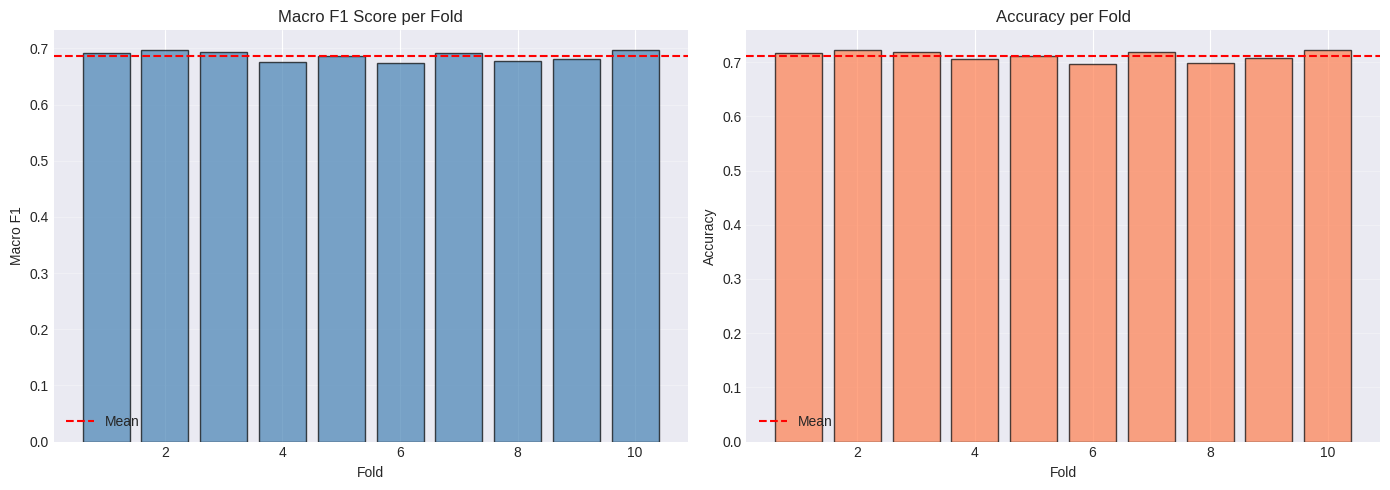

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(results_df['fold'], results_df['macro_f1'], color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axhline(y=results_df['macro_f1'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Macro F1')
axes[0].set_title('Macro F1 Score per Fold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(results_df['fold'], results_df['accuracy'], color='coral', edgecolor='black', alpha=0.7)
axes[1].axhline(y=results_df['accuracy'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy per Fold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


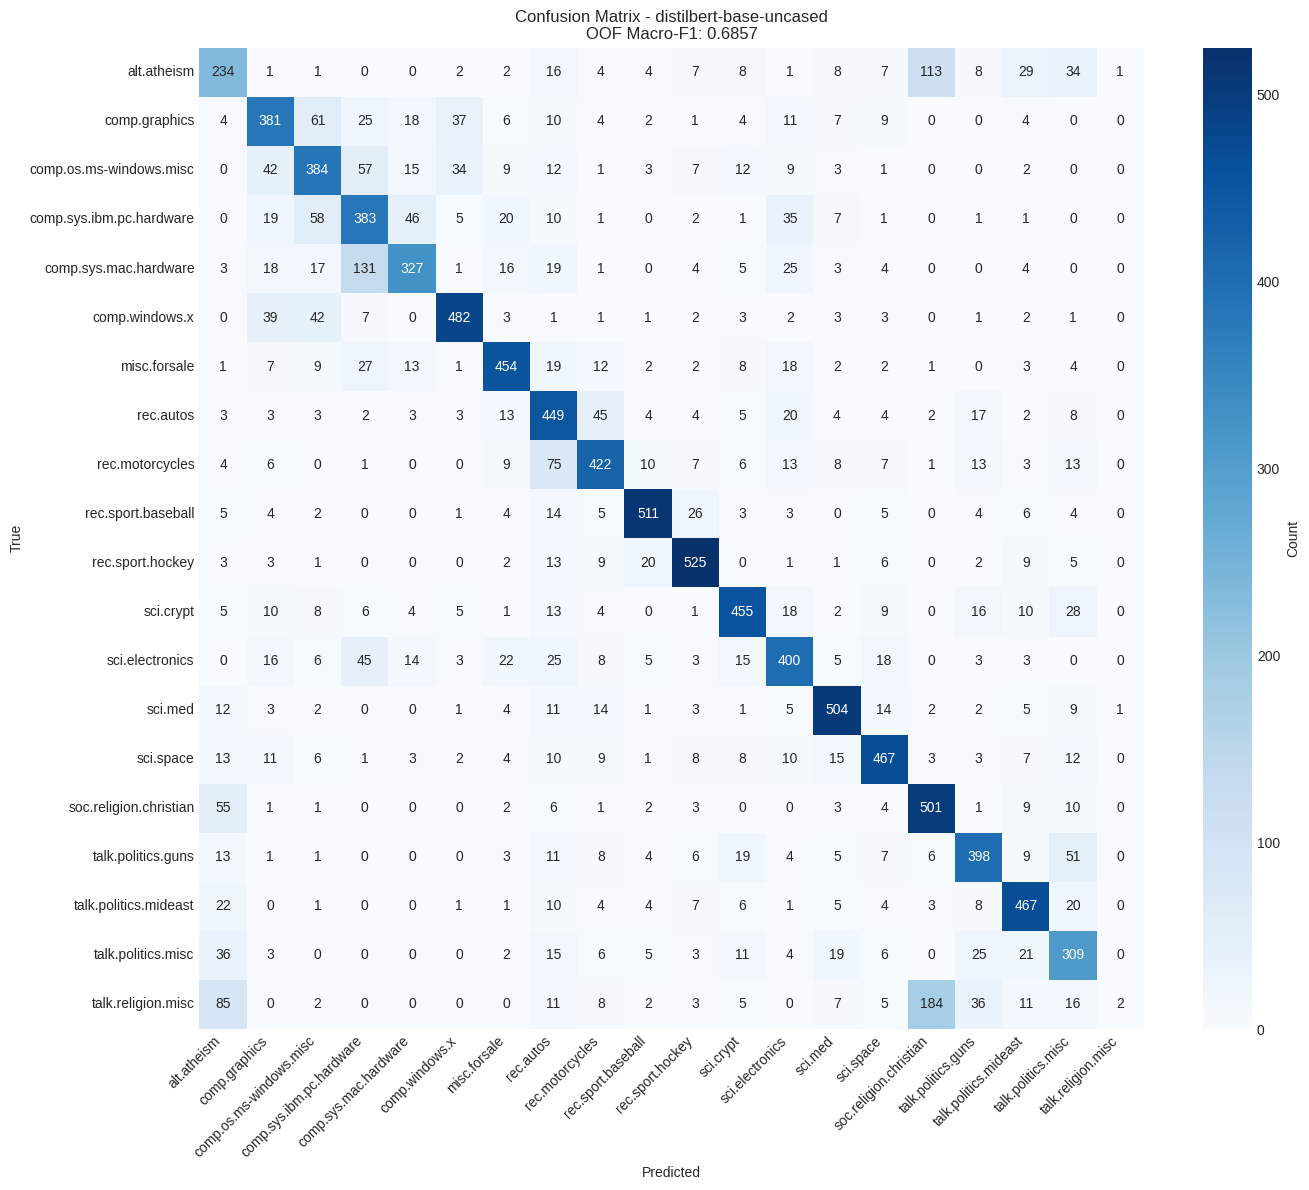

In [13]:
cm = confusion_matrix(labels_train, oof_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - {CONFIG["model_name"]}\nOOF Macro-F1: {oof_macro_f1:.4f}')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [14]:
print(f"{'='*80}")
print("CLASSIFICATION REPORT")
print(f"{'='*80}\n")

report = classification_report(labels_train, oof_preds, target_names=target_names, digits=4)
print(report)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_path = os.path.join(CONFIG['results_dir'], f'cv_results_{timestamp}.pkl')

with open(results_path, 'wb') as f:
    pickle.dump({
        'config': CONFIG,
        'fold_results': results_df,
        'oof_predictions': oof_preds,
        'oof_probabilities': oof_probs,
        'oof_macro_f1': oof_macro_f1,
        'classification_report': report
    }, f)

print(f"\nResults saved to: {results_path}")


CLASSIFICATION REPORT

                          precision    recall  f1-score   support

             alt.atheism     0.4699    0.4875    0.4785       480
           comp.graphics     0.6708    0.6524    0.6615       584
 comp.os.ms-windows.misc     0.6347    0.6497    0.6421       591
comp.sys.ibm.pc.hardware     0.5591    0.6492    0.6008       590
   comp.sys.mac.hardware     0.7381    0.5657    0.6405       578
          comp.windows.x     0.8339    0.8128    0.8232       593
            misc.forsale     0.7868    0.7761    0.7814       585
               rec.autos     0.5987    0.7559    0.6682       594
         rec.motorcycles     0.7443    0.7057    0.7245       598
      rec.sport.baseball     0.8795    0.8559    0.8676       597
        rec.sport.hockey     0.8413    0.8750    0.8578       600
               sci.crypt     0.7913    0.7647    0.7778       595
         sci.electronics     0.6897    0.6768    0.6832       591
                 sci.med     0.8249    0.8485    0.8

In [15]:
print(f"\n{'='*80}")
print("TEST SET EVALUATION")
print(f"{'='*80}\n")

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])

print("Pre-tokenizing test data...")
test_encodings = tokenize_texts(texts_test, tokenizer, CONFIG['max_length'], batch_size=1000)

test_dataset = PreTokenizedDataset(
    test_encodings['input_ids'],
    test_encodings['attention_mask'],
    labels_test
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'] * 2,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Test data prepared: {len(test_dataset):,} samples\n")

print("Training final model on full training set...")

train_full_encodings = tokenize_texts(texts_train, tokenizer, CONFIG['max_length'], batch_size=1000)

train_full_dataset = PreTokenizedDataset(
    train_full_encodings['input_ids'],
    train_full_encodings['attention_mask'],
    labels_train
)

train_full_loader = DataLoader(
    train_full_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

final_model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels']
).to(device)

no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in final_model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': CONFIG['weight_decay']
    },
    {
        'params': [p for n, p in final_model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=CONFIG['learning_rate'])

total_steps = len(train_full_loader) * CONFIG['num_epochs'] // CONFIG['gradient_accumulation_steps']
warmup_steps = int(total_steps * CONFIG['warmup_ratio'])
scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

for epoch in range(CONFIG['num_epochs']):
    print(f"Epoch {epoch+1}/{CONFIG['num_epochs']}")
    train_loss, train_f1, train_acc = train_epoch(final_model, train_full_loader, optimizer, scheduler, device, CONFIG)
    print(f"  Train Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Acc: {train_acc:.4f}")

print("\nEvaluating on test set...")
test_results = evaluate(final_model, test_loader, device, CONFIG)

print(f"\n{'='*80}")
print("TEST SET RESULTS")
print(f"{'='*80}")
print(f"Test Macro-F1: {test_results['macro_f1']:.4f}")
print(f"Test Weighted-F1: {test_results['weighted_f1']:.4f}")
print(f"Test Accuracy: {test_results['accuracy']:.4f}")
print(f"Test Loss: {test_results['loss']:.4f}")
print(f"{'='*80}\n")

model_path = os.path.join(CONFIG['save_dir'], 'final_model')
final_model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Final model saved to: {model_path}")



TEST SET EVALUATION

Pre-tokenizing test data...


Tokenizing:   0%|          | 0/8 [00:00<?, ?it/s]

Test data prepared: 7,532 samples

Training final model on full training set...


Tokenizing:   0%|          | 0/12 [00:00<?, ?it/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


Training:   0%|          | 0/708 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 2.0254 | F1: 0.4300 | Acc: 0.4529
Epoch 2/3


Training:   0%|          | 0/708 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 1.0498 | F1: 0.6835 | Acc: 0.7089
Epoch 3/3


Training:   0%|          | 0/708 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  Train Loss: 0.8291 | F1: 0.7432 | Acc: 0.7687

Evaluating on test set...


Evaluating:   0%|          | 0/236 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


TEST SET RESULTS
Test Macro-F1: 0.6619
Test Weighted-F1: 0.6787
Test Accuracy: 0.6859
Test Loss: 1.0536

Final model saved to: models/transformers/final_model


In [16]:
print(f"{'='*80}")
print("TEST SET CLASSIFICATION REPORT")
print(f"{'='*80}\n")

test_report = classification_report(
    test_results['labels'],
    test_results['predictions'],
    target_names=target_names,
    digits=4
)
print(test_report)


TEST SET CLASSIFICATION REPORT

                          precision    recall  f1-score   support

             alt.atheism     0.4096    0.4263    0.4178       319
           comp.graphics     0.6903    0.6761    0.6831       389
 comp.os.ms-windows.misc     0.6560    0.6777    0.6667       394
comp.sys.ibm.pc.hardware     0.6299    0.5383    0.5805       392
   comp.sys.mac.hardware     0.6293    0.6130    0.6211       385
          comp.windows.x     0.8351    0.7949    0.8145       395
            misc.forsale     0.8252    0.8231    0.8241       390
               rec.autos     0.7911    0.7172    0.7523       396
         rec.motorcycles     0.7161    0.6910    0.7033       398
      rec.sport.baseball     0.8810    0.8388    0.8594       397
        rec.sport.hockey     0.8946    0.8722    0.8832       399
               sci.crypt     0.7366    0.6919    0.7135       396
         sci.electronics     0.3949    0.6310    0.4858       393
                 sci.med     0.8346    0.82